## Load libraries

In [1]:
from matplotlib import pyplot as pl
import pandas as pd
import numpy as np
pl.style.use('fivethirtyeight')
pl.rcParams.update({
    'lines.linewidth': 2,
    'font.size': 20,
    'figure.figsize': [12, 8],
    'figure.subplot.left': 0.125,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.15})

## Load data and calculate new derived values

In [2]:
scotus_data = pd.read_csv('SCOTUS.csv',
                          parse_dates=['DOB', 'debut', 'retire', 'DOD'],
                          na_values='99/99/9999')

scotus_data.fillna(np.datetime64('2021-01-02'), inplace=True)
scotus_data['died in office']=(scotus_data['retire']==scotus_data['DOD']).astype(int)
scotus_data['days_since_last'] = scotus_data['debut'].diff()
scotus_data['years_since_last'] = scotus_data['days_since_last'].apply(lambda x: x.days)/365.24
scotus_data['age at start'] = (scotus_data['debut']-scotus_data['DOB']).apply(lambda x: x.days)/365.24
scotus_data['age at end'] = (scotus_data['retire']-scotus_data['DOB']).apply(lambda x: x.days)/365.24
scotus_data['years of service'] = (scotus_data['retire']-scotus_data['debut']).apply(lambda x: x.days)/365.24

years = np.array([np.datetime64(str(yr)+'-01-01') for yr in np.arange(1791,2022)])
ages = []
for year in years:
    ages.append((year - scotus_data.loc[(scotus_data.debut<year) & (scotus_data.retire>year), 'DOB']).mean())    

average_age = pd.DataFrame(ages, index=years, columns=['days'])
average_age['years'] = average_age['days'].apply(lambda x: x.days)/365.24

### Average age of court
On January 1 of each year, calculate the average age of the currently serving justices.

Text(0, 0.5, 'average age (years)')

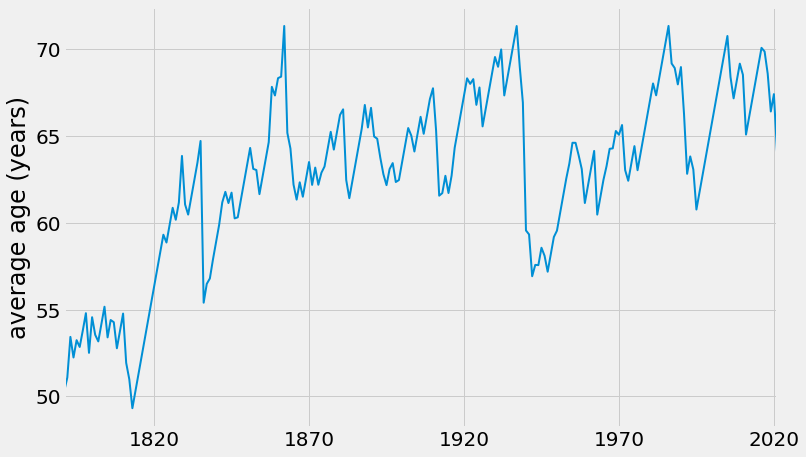

In [3]:
average_age['years'].plot()
pl.ylabel('average age (years)')

## Distance between appointments

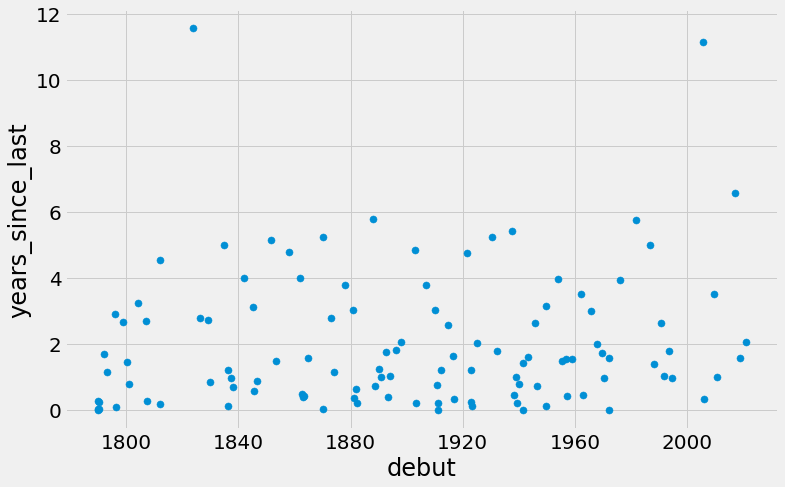

In [4]:
scotus_data.plot.scatter('debut','years_since_last', s=50)

## Age at appointment over time

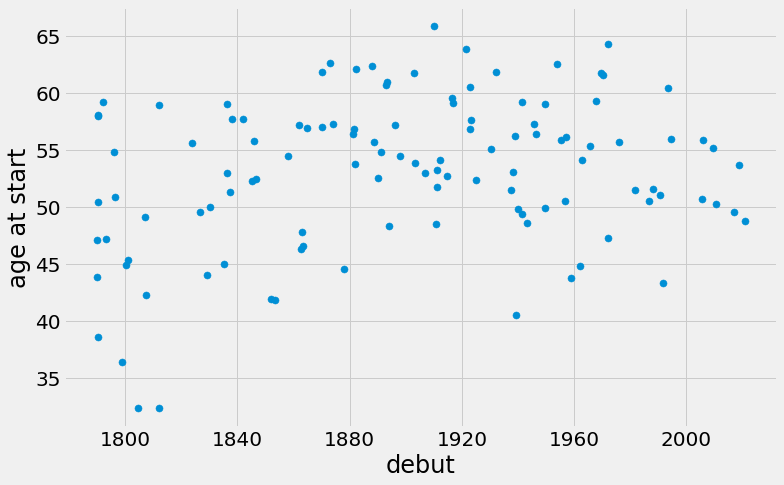

In [5]:
scotus_data.plot.scatter('debut','age at start', s=50)

## Years of service at retirement
Excludes those currently serving. Color codes mark those who retired vs. those who died while still serving in office.

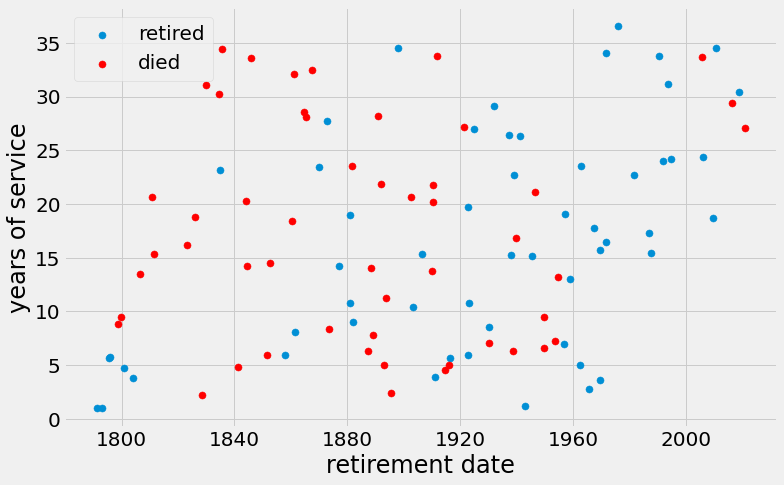

In [6]:
from matplotlib import colors
ys_data = scotus_data.sort_values('retire')[:-9].rename(columns={'retire':'retirement date'})
ax = ys_data[ys_data['died in office']==0].plot.scatter('retirement date', 'years of service', s=50, label='retired')
ys_data[ys_data['died in office']==1].plot.scatter('retirement date', 'years of service', s=50, c='r', label='died', ax=ax)

## Stats by eras
1970 appears to be something of a turning point. Since then, no justice has retired or died after serving fewer than 15 years. Using 1970 as a reference point, all justices have been grouped into 50-year eras based on their retirement date. In the period since 1970, relative to previous eras, justices are appointed younger, retire older, and are far less likely to die in office.

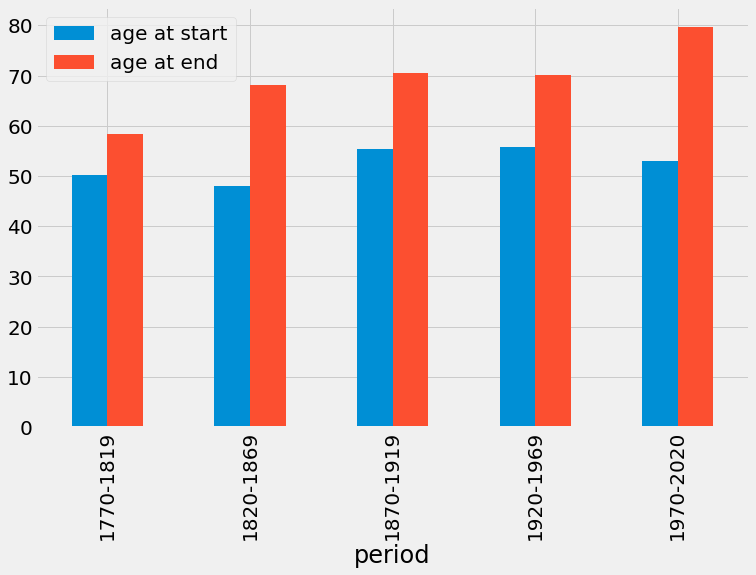

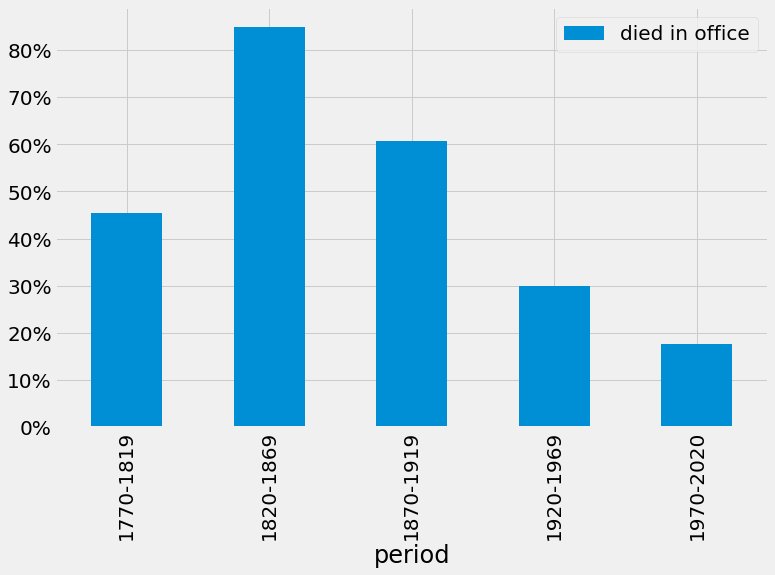

In [7]:
ps = ys_data['retirement date'].apply(lambda x: int((x.year-20)/50)*50+20)
ps.iloc[-1] = 1970
ys_data['period'] = ps.apply(lambda x: '{0:d}-{1:d}'.format(x, x+(50 if x==1970 else 49)))


period_analysis = ys_data.groupby('period').mean()[['years of service', 'age at start', 'age at end', 'died in office']]
period_analysis['number'] = ys_data.groupby('period').size()
period_analysis[['age at start', 'age at end']].plot.bar()

import matplotlib.ticker as mtick
ax = (period_analysis[['died in office']]*100).plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Appointments per presidential term
Calculate the beginning date of the presidential term for each appointment and use that to compute the number of appointments in each presidential term since 1789. Compute the averages before the term beginning in 1973 (excluding the 1789 term when the entire court was appointed in a single term), and the average after 1973.

In [8]:
scotus_data['pres_term'] = scotus_data['debut'].apply(lambda x: int((x.year-1)/4)*4+1)
appoints_per_term = pd.DataFrame(index=range(1789,2021,4))
appoints_per_term['appoints'] = 0

for idx, vals in scotus_data.iterrows():
    appoints_per_term.loc[vals['pres_term'], 'appoints'] += 1

print('Court appointments per presidential term, 1793-1973: {0:.2f}'.format(appoints_per_term[1:-12]['appoints'].mean()))
print('Court appointments per presidential term, 1973-2021: {0:.2f}'.format(appoints_per_term[-12:]['appoints'].mean()))

Court appointments per presidential term, 1793-1973: 2.07
Court appointments per presidential term, 1973-2021: 1.25
